# Segmentação
Referências: <br>
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html <br>
https://scikit-image.org/docs/dev/api/skimage.segmentation.html
***

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from skimage.segmentation import felzenszwalb,slic,quickshift,watershed
from skimage.color import rgb2gray
from skimage.filters import sobel

In [3]:
import time 

last_time  = time.time()
#function of time, milliseconds of last tic() 
#reset difine if you want clear the clock for ne next tic()
def tic(reset = True):
    global last_time
    toc = time.time()
    delta = toc - last_time
    if reset:
        last_time = toc
    return delta*1000

In [4]:
def pinta_contorno(im_contornar, contorno, lineThickness=1):
    im_contorno = im_contornar.copy()
    return cv2.drawContours(im_contornar, [contorno], 0, (0,0,0), lineThickness)

## Funcoes de imshow

In [5]:
#minha funcao para mostrar as imagens
def imshow(im,big=False):
    if big:
        plt.figure(figsize=(20,20))
    else:
        plt.figure()
    if len(im.shape)<3:
        plt.imshow(im, cmap='gray')#As cores ficam zoadas no Jupyter se deixar sem esse parâmetro
    else:
        plt.imshow(im[:,:,::-1]) 
    plt.axis('off')
    plt.show()

In [6]:
#pinta uma matriz de labels com cores diferentes
def pinta_blobs(labels,angle_delta=20):
    #cria imagens
    im_hsv = np.ones((labels.shape[0],labels.shape[1],3)).astype('uint8')*255
    
    #printa usando a mascara
    im_hsv[:,:,0] = (labels*angle_delta)%180

    return cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR)

#pinta uma matriz de labels com a media de cores de im 
def pinta_blobs2(labels,im):
    n_labels = int(labels.max()+1)
    im_out = np.zeros(im.shape)
    
    #divide por canal
    b,g,r    = im[:,:,0],im[:,:,1],im[:,:,2]
    bo,go,ro = im_out[:,:,0],im_out[:,:,1],im_out[:,:,2]
    
    for label in range(n_labels):
        mask = labels==label
        bo[mask] += np.median(b[mask])#b[mask].mean()
        go[mask] += np.median(g[mask])#g[mask].mean()
        ro[mask] += np.median(r[mask])#r[mask].mean()
    return im_out.astype('uint8')

## Abre imagem

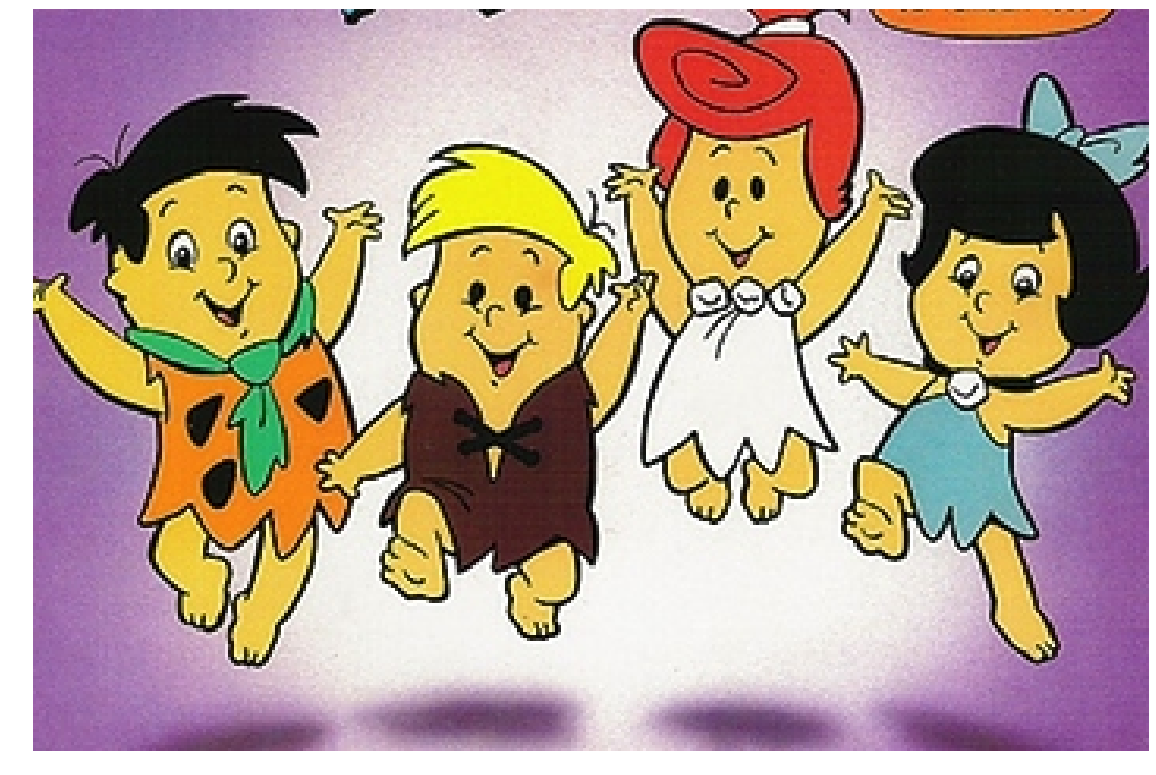

In [7]:
im = cv2.imread('imgs/1.jpg')
imshow(im, True)

***
# Quickshift

In [8]:
regioes = quickshift(im, kernel_size=3, max_dist=6, ratio=0.5)

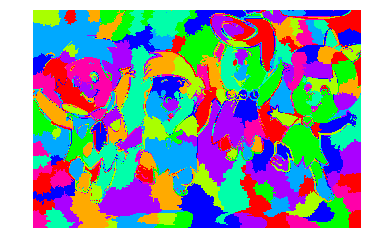

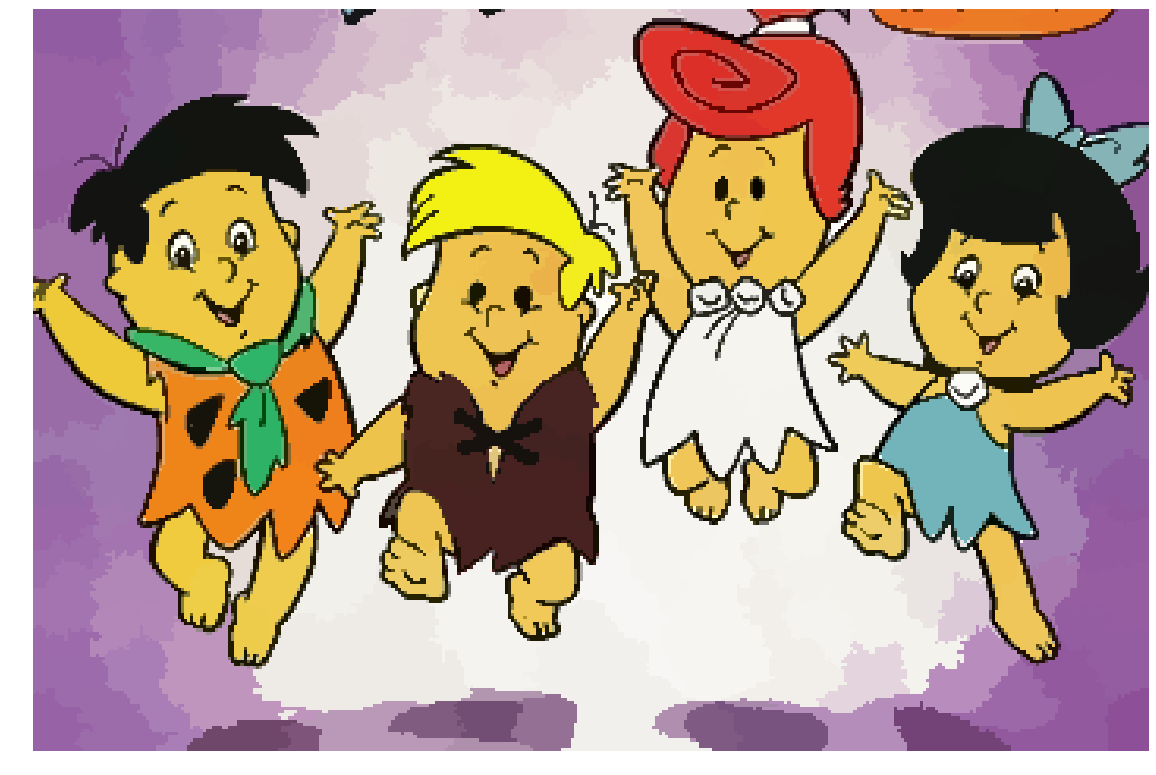

In [9]:
imshow(pinta_blobs(regioes))
imshow(pinta_blobs2(regioes,im),True)

In [10]:
def encontra_contornos(regioes):
    contornos_por_regiao = []
    
    for i in range(regioes.max() + 1):
        mascara = (regioes == i).astype("uint8") * 255
        contornos,h = cv2.findContours(mascara,mode=cv2.RETR_TREE,method = cv2.CHAIN_APPROX_SIMPLE)
        contornos_por_regiao.append(contornos)

    return contornos_por_regiao

contornos_por_regiao = encontra_contornos(regioes)

### Visualização dos contornos encontrados

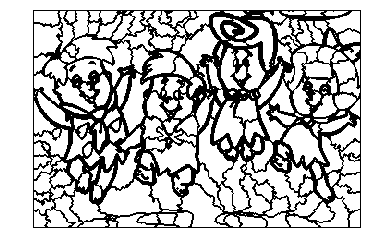

In [11]:
im_branca = np.ones(im.shape).astype('uint8')*255
for contornos_da_regiao in contornos_por_regiao:
    for contorno in contornos_da_regiao:
        im_branca = pinta_contorno(im_branca, contorno, 1)

imshow(im_branca)

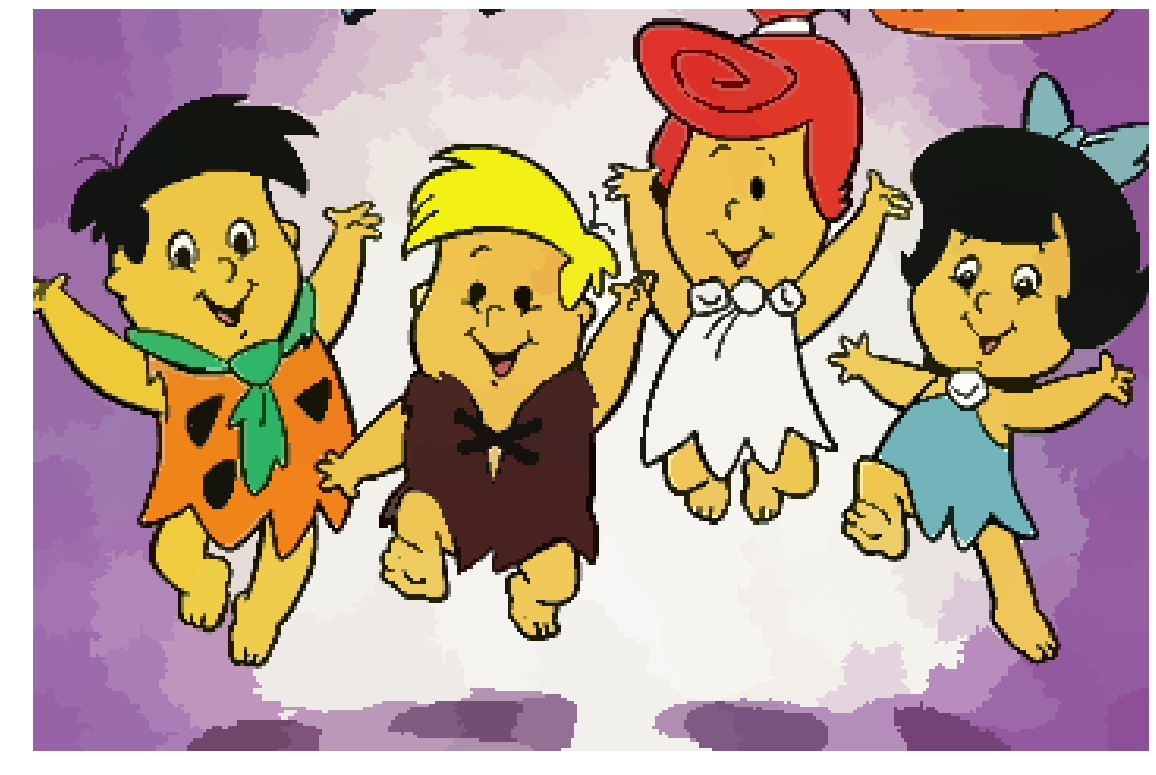

In [15]:
def pinta_regioes(im_entrada, regioes, contornos_por_regiao):
    im_out = np.ones(im_entrada.shape).astype('uint8')*255

    #divide por canal
    b,g,r = im_entrada[:,:,0],im_entrada[:,:,1],im_entrada[:,:,2]

    for label_regiao in range(regioes.max()+1):
        mask = (regioes == label_regiao)
        bo = np.median(b[mask])
        go = np.median(g[mask])
        ro = np.median(r[mask])

        for contorno in contornos_por_regiao[label_regiao]:
            cv2.drawContours(im_out, [contorno], 0, (bo,go,ro), -1), True
    
    return im_out

im_regioes_pintadas = pinta_regioes(im, regioes, contornos_por_regiao)
imshow(im_regioes_pintadas, True)